In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from src.models.buffered_cv import BufferedBlockedSplit
import src.features.build_features as feat

idx = pd.IndexSlice

In [2]:
data_path = Path('../data/processed/cup_10_min_aggs.parquet')
assert data_path.exists()

In [3]:
met = pd.read_parquet(data_path)
met.head(1).T

timestamp                              2018-12-31 17:00:00
Air_Temp_87m   count                            600.000000
               max                              -15.477113
               mean                             -15.691004
               min                              -15.805410
               var                                0.002746
Cup_WS_C1_105m 3s_gust                            8.805074
               count                            600.000000
               integrated_low_freq_ke             0.212934
               max                                8.917205
               mean                               7.490526
               min                                5.818164
               var                                0.288631
Cup_WS_C1_130m 3s_gust                            8.685490
               count                            600.000000
               integrated_low_freq_ke             0.195348
               max                                9.123878
               mean                               7.629745
               min                                6.183786
               var                                0.257707
DeltaT_122_87m count                            600.000000
               max                               -0.274433
               mean                              -0.304441
               min                               -0.330359
               var                                0.000068
Vane_WD_122m   count                            600.000000
               max                               33.494219
               mean                              22.310701
               min                               11.305162
               var                               15.631823
Vane_WD_87m    count                            600.000000
               max                               36.993735
               mean                              23.033820
               min                               10.439399
               var                               17.199339

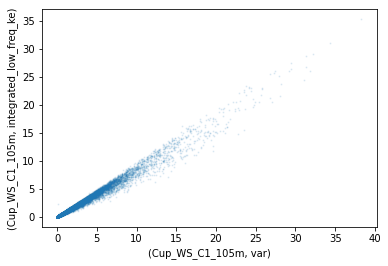

In [4]:
met.plot.scatter(('Cup_WS_C1_105m', 'var'), ('Cup_WS_C1_105m', 'integrated_low_freq_ke'), alpha=0.1, s=1)

From the plot above, linear regression is an obvious choice of baseline model. But first I'll do some feature engineering.
# Feature engineering
## Cyclic features
There are three cyclic features here: wind direction (angle), time of year (seasonal cycle), and time of day (diurnal cycle). In each case, points at the beginning and end of the data ranges are actually adjacent: 0 degrees is close to 359 degreees, January is close to December, and 00:01 is close to 23:59. These cyclic relationships can't be captured by a single dimension, so I'll convert them to 2 component dimensions with sine and cosine transforms.
### Time of Year
Of course the calendar itself is not causal - time of year is a proxy for the earth's axial tilt and associated seasonality effects.

Time of year may not add much predictive value for this use case because of the single year of data and blocked CV schema. This means large chunks of a season will be held out, forcing the model to perform long-range interpolation or even extrapolation, hurting performance. But I think it is still a preferred outcome to the non-blocked alternative: overconfident CV due to data leakage from autocorrelation.
### Time of Day
Like time of year, time of day is a proxy variable for a separate causal mechanism: incident solar radiation and associated processes.

In [37]:
minute_of_day = met.index.hour * 60 + met.index.minute
minute_of_year = (met.index.dayofyear - 1) * 60 * 24 + minute_of_day # dayofyear starts at 1; shift -1 to zero-index
# scale to radians
minute_of_day *= 2 * np.pi / (24 * 60)
minute_of_year *= 2 * np.pi / (365 * 24 * 60) # data is from 2019 so I'll ignore leap years

In [38]:
# check. Maxes are different due to different resolutions
# 144 10 minute periods per day, 52560 10 min periods per year
minute_of_day.min(), minute_of_day.max(), minute_of_year.min(), minute_of_year.max()

(0.0, 6.239552075879728, 0.0, 6.283065764080135)

In [39]:
met.loc[:, ('derived', 'season_sin')] = np.sin(minute_of_year)
met.loc[:, ('derived', 'season_cos')] = np.cos(minute_of_year)
met.loc[:, ('derived', 'day_sin')] = np.sin(minute_of_day)
met.loc[:, ('derived', 'day_cos')] = np.cos(minute_of_day)

### Wind Direction
There are two wind direction measurements at different heights. Rather than using two highly correlated features (4 after sine/cosine transform), I'll express them in terms of a reference direction and the difference between them (called veer). Furthermore, I'll cast the difference in terms of a gradient wrt to height, for greater feature portability between differently-instrumented towers. I'll leave the difference as a single dimension with range (-180, 180], simply because there will rarely be differences more than 90 degrees, so cyclic wrapping is less of a concern.

Finally, I could save a dimension and combine wind speed with sin/cos transforms of wind direction, creating vector components. But speed is such a critical feature that I think it's worth leaving separate. It is easier to interpret and to combine with the other aggregate features based on magnitude: min, max, 3s_gust, and var.

In [40]:
# gradients wrt height
subset = ['max', 'min', 'var']
met.loc[:, idx['Vane_WD_122m', subset]] = (met.loc[:, idx['Vane_WD_122m', subset]] - 
                                          met.loc[:, idx['Vane_WD_87m', subset]]) / (122 - 87)
met.loc[:, idx['Vane_WD_122m', 'veer_rate']] = feat.angular_difference(met.loc[:, idx['Vane_WD_122m', 'mean']],
                                                                 met.loc[:, idx['Vane_WD_87m', 'mean']]) / (122 - 87)
met = met.rename(columns={'Vane_WD_122m' : 'vane_diff'}, level=0)

In [ ]:
met.loc[:, ('derived', 'dir_87_sin')] = np.sin(minute_of_year)
met.loc[:, ('derived', 'dir_87_cos')] = np.cos(minute_of_year)

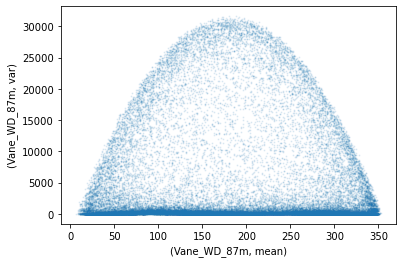

In [42]:
met.plot.scatter(('Vane_WD_87m', 'mean'), ('Vane_WD_87m', 'var'), alpha=0.1, s=1)

## Domain Specific Features
In a full application, I would add more domain specific features like bulk richardson number and monin-obukhov length. But the combination of wind shear, temperature gradient, and directional veer provide similar information.

To express information about wind speed vs height, I'll compute the wind shear exponent. 

Like wind direction, I'll express the two temperature measurements in terms of a reference and difference, with the difference as a gradient wrt height. This is just a linear transform so shouldn't change much in the models; the purpose is to make the same features applicable to other towers that have sensors in different places.

In [45]:
met.loc[:, ('derived', 'shear_exp')] = feat.power_law_shear(met.loc[:,('Cup_WS_C1_130m', 'mean')],
                                                        met.loc[:,('Cup_WS_C1_105m', 'mean')],
                                                        130,
                                                        105)

In [46]:
met.loc[:, idx['DeltaT_122_87m', 'max':]] = met.loc[:, idx['DeltaT_122_87m', 'max':]] / (122 - 87)
met = met.rename(columns={'DeltaT_122_87m' : 'DeltaT_rate'}, level=0)

In [48]:
met.head(1).T

timestamp                              2018-12-31 17:00:00
Air_Temp_87m   count                            600.000000
               max                              -15.477113
               mean                             -15.691004
               min                              -15.805410
               var                                0.002746
Cup_WS_C1_105m 3s_gust                            8.805074
               count                            600.000000
               integrated_low_freq_ke             0.212934
               max                                8.917205
               mean                               7.490526
               min                                5.818164
               var                                0.288631
Cup_WS_C1_130m 3s_gust                            8.685490
               count                            600.000000
               integrated_low_freq_ke             0.195348
               max                                9.123878
               mean                               7.629745
               min                                6.183786
               var                                0.257707
DeltaT_rate    count                            600.000000
               max                               -0.007841
               mean                              -0.008698
               min                               -0.009439
               var                                0.000002
Vane_WD_122m   count                            600.000000
               max                               33.494221
               mean                              22.310926
               min                               11.305159
               var                               15.657919
veer_rate      count                            600.000000
               max                               -0.099986
               mean                              -0.020661
               min                                0.024736
               var                               -0.044861
metrics        shear_exp                          0.086226

# Complete Case Analysis
I'll drop rows where data availability was poor

In [52]:
len(met)

(52560, 49332)

In [55]:
threshold = 0.8
mask = met.loc[:, idx[:, 'count']].min(axis=1) >= (threshold * 600)
met = met.loc[mask,:].dropna()
len(met)

48653

# Baseline - linear regression

In [51]:
from sklearn.linear_model import LinearRegression

